## 1. Load the dataset 
- First load the dataset and then do pre-processing on it 




In [6]:


import os
from PIL import Image
import numpy as np



# 2. Raw vs. cleaned folders
raw_img_dir   = '/kaggle/input/cvcclinicdb/PNG/Original'
raw_mask_dir  = '/kaggle/input/cvcclinicdb/PNG/Ground Truth'
clean_img_dir = '/kaggle/cleaned_images'
clean_mask_dir= '/kaggle/cleaned_masks'

os.makedirs(clean_img_dir,  exist_ok=True)
os.makedirs(clean_mask_dir, exist_ok=True)

# 3. Clean function: resize to 256×256, binarize mask
def clean_and_save(in_img_dir, in_mask_dir, out_img_dir, out_mask_dir, size=(256,256)):
    img_files  = sorted([f for f in os.listdir(in_img_dir)  if f.lower().endswith('.png')])
    mask_files = sorted([f for f in os.listdir(in_mask_dir) if f.lower().endswith('.png')])
    common_ids = sorted(set(os.path.splitext(f)[0] for f in img_files)
                        & set(os.path.splitext(f)[0] for f in mask_files))

    for img_id in common_ids:
        img_path  = os.path.join(in_img_dir,  img_id + '.png')
        msk_path  = os.path.join(in_mask_dir, img_id + '.png')
        img       = Image.open(img_path).convert('RGB').resize(size)
        mask      = Image.open(msk_path).convert('L').resize(size)

        mask_np   = np.array(mask)
        bin_mask  = (mask_np > 127).astype(np.uint8) * 255

        img.save(os.path.join(out_img_dir,  img_id + '.png'))
        Image.fromarray(bin_mask).save(os.path.join(out_mask_dir, img_id + '.png'))

# Run the cleaning once
clean_and_save(raw_img_dir, raw_mask_dir, clean_img_dir, clean_mask_dir)


## 2. Split the dataset into 3 part traning,validation and testing. 
- training = 70%
- validation = 20%
- testing = 10%

In [8]:

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import os
from PIL import Image

# Custom Dataset
class CVCClinicDBDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.ids = sorted(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.lower().endswith('.png'))
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img = Image.open(os.path.join(self.image_dir, img_id + '.png')).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_id + '.png')).convert('L')
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

# Transform
transform = T.Compose([T.ToTensor()])

# Paths (Update these!)
clean_img_dir = '/kaggle/cleaned_images'
clean_mask_dir= '/kaggle/cleaned_masks'


# Instantiate Dataset
dataset = CVCClinicDBDataset(clean_img_dir, clean_mask_dir, transform)

# Split Dataset
total = len(dataset)
train_len = int(0.7 * total)
val_len = int(0.2 * total)
test_len = total - train_len - val_len

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

# DataLoaders
batch_size = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)


## 3. Define the model 
- simpleCNN
- DeepLabV3+

In [12]:
# 2. Define Models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.conv1x1 = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.conv1x1(x)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return torch.sigmoid(x)

# # ResNetUNet
# class ResNetUNet(nn.Module):
#     def __init__(self, pretrained=True):
#         super(ResNetUNet, self).__init__()
#         backbone = models.resnet50(pretrained=pretrained)
#         self.layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool)
#         self.layer1 = backbone.layer1
#         self.layer2 = backbone.layer2
#         self.layer3 = backbone.layer3
#         self.layer4 = backbone.layer4

#         def double_conv(in_ch, out_ch):
#             return nn.Sequential(
#                 nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_ch),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_ch),
#                 nn.ReLU(inplace=True)
#             )

#         self.up4 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
#         self.dec4 = double_conv(2048, 1024)

    #     
        d3 = torch.cat([d3, x2], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torself.up3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    #     self.dec3 = double_conv(1024, 512)

    #     self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    #     self.dec2 = double_conv(512, 256)

    #     self.up1 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
    #     self.dec1 = double_conv(128, 128)

    #     self.up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    #     self.final = nn.Conv2d(64, 1, kernel_size=1)

    # def forward(self, x):
    #     x0 = self.layer0(x)
    #     x1 = self.layer1(x0)
    #     x2 = self.layer2(x1)
    #     x3 = self.layer3(x2)
    #     x4 = self.layer4(x3)

    #     d4 = self.up4(x4)
    #     d4 = torch.cat([d4, x3], dim=1)
    #     d4 = self.dec4(d4)

    #     d3 = self.up3(d4)ch.cat([d2, x1], dim=1)
        # d2 = self.dec2(d2)

        # d1 = self.up1(d2)
        # d1 = torch.cat([d1, x0], dim=1)
        # d1 = self.dec1(d1)

        # d0 = self.up0(d1)
        # out = self.final(d0)
        # return torch.sigmoid(out)

# DeepLabV3+
class DeepLabV3Plus(nn.Module):
    def __init__(self, pretrained=True):
        super(DeepLabV3Plus, self).__init__()
        self.backbone = models.segmentation.deeplabv3_resnet50(pretrained=pretrained)
        self.backbone.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)['out']
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return torch.sigmoid(x)


## 4. Train both the models

In [13]:
# 3. Training
import numpy as np
from sklearn.metrics import jaccard_score

def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    best_iou, best_model = -1, model.state_dict()

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), (masks.to(device) > 0.5).float()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        
        val_loss = 0
        all_preds, all_truth = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), (masks.to(device) > 0.5).float()
                outputs = model(imgs)
                val_loss += criterion(outputs, masks).item() * imgs.size(0)
                all_preds.append((outputs>0.5).cpu().view(imgs.size(0),-1).numpy())
                all_truth.append(masks.cpu().view(imgs.size(0),-1).numpy())
        
        preds = np.concatenate(all_preds).ravel()
        truth = np.concatenate(all_truth).ravel()
        val_iou = jaccard_score(truth, preds, zero_division=0)

        print(f"Epoch {epoch}/{epochs}  Train Loss={running_loss/len(train_loader.dataset):.4f}  Val Loss={val_loss/len(val_loader.dataset):.4f}  Val IoU={val_iou:.4f}")

        if val_iou > best_iou:
            best_iou = val_iou
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model

# Train
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models_dict = {
    'SimpleCNN': SimpleCNN().to(device),
    #'ResNetUNet': ResNetUNet(pretrained=True).to(device),
    'DeepLabV3Plus': DeepLabV3Plus(pretrained=True).to(device),
}
trained_models = {}
for name, model in models_dict.items():
    print(f"\nTraining {name}…")
    trained_models[name] = train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training SimpleCNN…
Epoch 1/10  Train Loss=0.4546  Val Loss=0.3451  Val IoU=0.0000
Epoch 2/10  Train Loss=0.2723  Val Loss=0.2680  Val IoU=0.0000
Epoch 3/10  Train Loss=0.2464  Val Loss=0.2620  Val IoU=0.0000
Epoch 4/10  Train Loss=0.2399  Val Loss=0.2664  Val IoU=0.0000
Epoch 5/10  Train Loss=0.2387  Val Loss=0.2594  Val IoU=0.0133
Epoch 6/10  Train Loss=0.2353  Val Loss=0.2563  Val IoU=0.0091
Epoch 7/10  Train Loss=0.2344  Val Loss=0.2546  Val IoU=0.0216
Epoch 8/10  Train Loss=0.2336  Val Loss=0.2577  Val IoU=0.0094
Epoch 9/10  Train Loss=0.2326  Val Loss=0.2548  Val IoU=0.0415
Epoch 10/10  Train Loss=0.2308  Val Loss=0.2532  Val IoU=0.0351

Training DeepLabV3Plus…
Epoch 1/10  Train Loss=0.2562  Val Loss=0.2037  Val IoU=0.4405
Epoch 2/10  Train Loss=0.1704  Val Loss=0.1785  Val IoU=0.4365
Epoch 3/10  Train Loss=0.1402  Val Loss=0.1692  Val IoU=0.5382
Epoch 4/10  Train Loss=0.1231  Val Loss=0.1378  Val IoU=0.5475
Epoch 5/10  Train Loss=0.1104  Val Loss=0.1133  Val IoU=0.6243
Epoch 6/

In [16]:
# Dice and IoU Functions
def dice_score(pred, target):
    smooth = 1e-7
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target):
    smooth = 1e-7
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)


## 5. Test result 

In [31]:
# # Evaluation and Visualization
# import matplotlib.pyplot as plt
# import random

# def evaluate(model, loader):
#     model.eval()
#     iou_total, dice_total, n = 0, 0, 0
#     with torch.no_grad():
#         for imgs, masks in loader:
#             imgs, masks = imgs.to(device), masks.to(device)
#             probs = model(imgs)
#             preds = (probs > 0.5).float()
#             for p, m in zip(preds, masks):
#                 iou_total += iou_score(p, m).item()
#                 dice_total += dice_score(p, m).item()
#                 n += 1
#     return iou_total/n, dice_total/n

# def visualize_predictions(model, dataset, num_samples=3):
#     model.eval()
#     picks = random.sample(range(len(dataset)), num_samples)
#     fig, axs = plt.subplots(num_samples, 3, figsize=(12, num_samples*4))
#     for i, idx in enumerate(picks):
#         img, true_mask = dataset[idx]
#         img = img.unsqueeze(0).to(device)
#         with torch.no_grad():
#             pred = model(img)[0,0].cpu().numpy()
#         axs[i,0].imshow(img.squeeze(0).permute(1,2,0).cpu())
#         axs[i,0].set_title("Image")
#         axs[i,1].imshow(true_mask.squeeze(), cmap='gray')
#         axs[i,1].set_title("Ground Truth")
#         axs[i,2].imshow(pred > 0.5, cmap='gray')
#         axs[i,2].set_title("Prediction")
#         for ax in axs[i]:
#             ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Final Evaluation
# for name, model in trained_models.items():
#     iou, dice = evaluate(model, test_loader)
#     print(f"{name:12s} IoU: {iou:.4f}, Dice: {dice:.4f}")

#     print(f"Sample Predictions for {name}:")
#     visualize_predictions(model, test_ds, num_samples=3)



SimpleCNN on test set:
  Accuracy : 0.9133
  Precision: 0.1649
  IoU      : 0.0138
  Dice     : 0.0230

Sample Predictions for SimpleCNN:


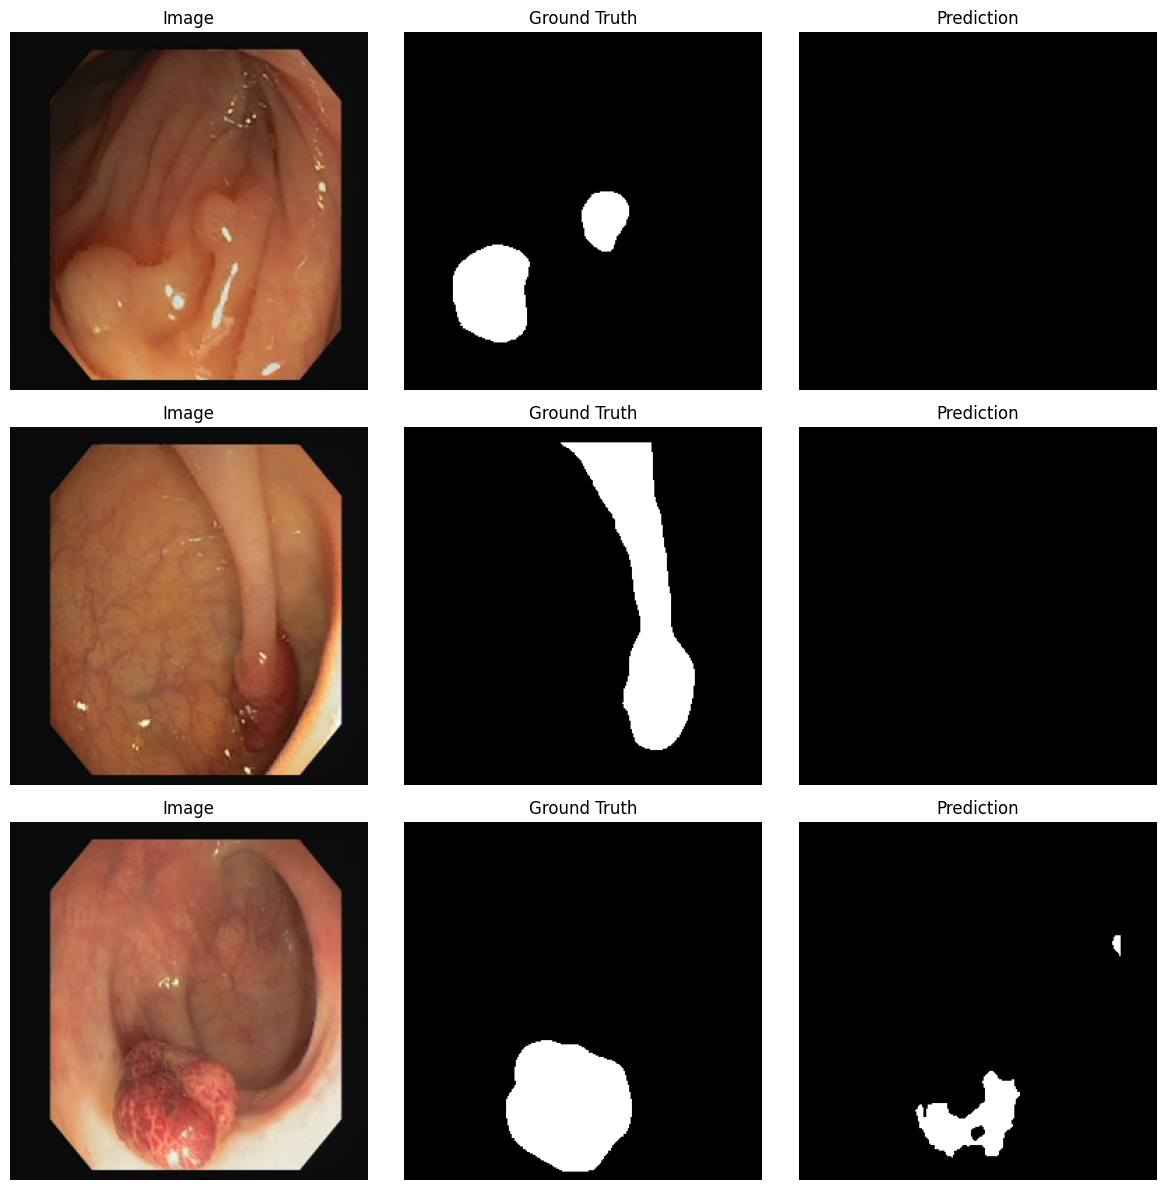


DeepLabV3Plus on test set:
  Accuracy : 0.9734
  Precision: 0.8552
  IoU      : 0.7301
  Dice     : 0.8233

Sample Predictions for DeepLabV3Plus:


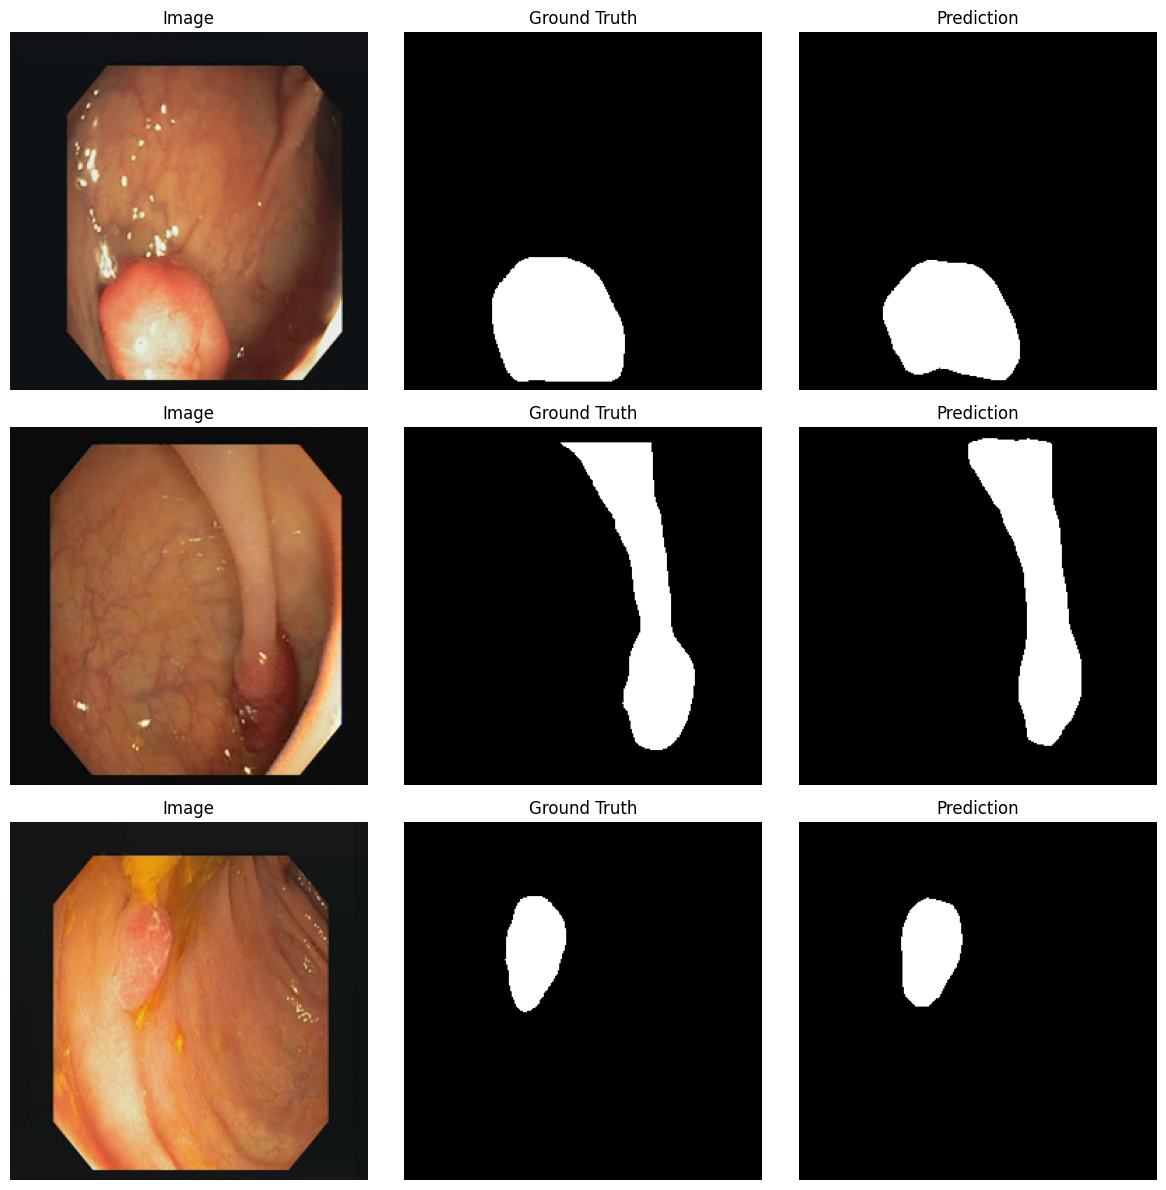

In [30]:
# ── Evaluation and Visualization with Accuracy & Precision ──
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score

def evaluate(model, loader):
    """
    Returns per-image averaged: IoU, Dice, Accuracy, Precision.
    """
    model.eval()
    iou_total, dice_total = 0.0, 0.0
    acc_total, prec_total = 0.0, 0.0
    n = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = (model(imgs) > 0.5).float()

            for p, m in zip(preds, masks):
                # IoU & Dice
                iou_total  += iou_score(p, m).item()
                dice_total += dice_score(p, m).item()
                # flatten for acc & precision
                p_flat = p.view(-1).cpu().numpy().astype(int)
                m_flat = (m.view(-1) > 0.5).cpu().numpy().astype(int)
                acc_total  += accuracy_score(m_flat, p_flat)
                prec_total += precision_score(m_flat, p_flat, zero_division=0)
                n += 1

    return {
        'IoU':       iou_total / n,
        'Dice':      dice_total / n,
        'Accuracy':  acc_total / n,
        'Precision': prec_total / n
    }

def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    picks = random.sample(range(len(dataset)), num_samples)
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, num_samples*4))

    for i, idx in enumerate(picks):
        img, true_mask = dataset[idx]
        inp = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_prob = model(inp)[0,0].cpu().numpy()

        axs[i,0].imshow(img.permute(1,2,0))
        axs[i,0].set_title("Image")
        axs[i,1].imshow(true_mask.squeeze(), cmap='gray')
        axs[i,1].set_title("Ground Truth")
        axs[i,2].imshow(pred_prob > 0.5, cmap='gray')
        axs[i,2].set_title("Prediction")
        for ax in axs[i]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# ── Run full evaluation ──
for name, model in trained_models.items():
    metrics = evaluate(model, test_loader)
    print(f"\n{name} on test set:")
    print(f"  Accuracy : {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  IoU      : {metrics['IoU']:.4f}")
    print(f"  Dice     : {metrics['Dice']:.4f}")

    print(f"\nSample Predictions for {name}:")
    visualize_predictions(model, test_ds, num_samples=3)


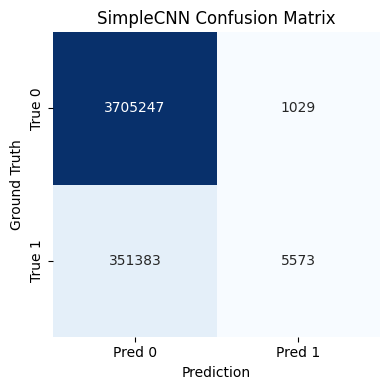

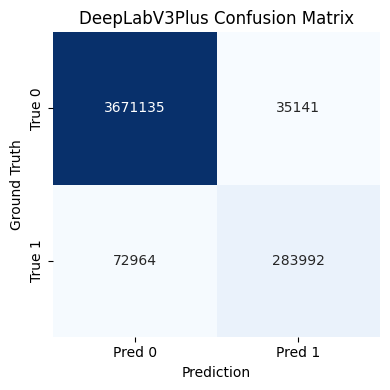

In [32]:
# ── Confusion Matrix for Each Model ──
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, loader, device, model_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            gt_flat   = (masks.to(device) > 0.5).view(-1).int().cpu().numpy()
            pred_flat = (model(imgs).view(-1) > 0.5).int().cpu().numpy()
            y_true.append(gt_flat)
            y_pred.append(pred_flat)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm, annot=True, fmt='d', cbar=False,
        xticklabels=["Pred 0","Pred 1"],
        yticklabels=["True 0","True 1"],
        cmap="Blues"
    )
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.tight_layout()
    plt.show()

# Call for each of your trained models:
for name, model in trained_models.items():
    plot_confusion_matrix(model, test_loader, device, name)
